In [28]:
import numpy as np
import sympy as smp
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

<div style="text-align: center;">
    <img src="Pendulo.png" alt="Pendulum Image">
</div>

Para estudiar este problema consideramos que las oscilaciones de nuestro sistema se acercan a la posición de equilibrio relativo. Por lo tanto, podemos suponer: $$J_1 = J_2$$

Por lo tanto, para el estado de equilibrio relativo los ángulos $\varphi_{10}$ y $\varphi_{20}$ son iguales, y entonces podemos escribir: $$\rho = b + \xi (t)$$ $$\varphi_1 = \varphi_0 + \varphi (t)$$ $$\varphi_2 = \varphi_0 + \psi (t)$$

Se definen los parametros y funciones a utilizar:
- $m$: Masa del disco
- $\omega$: Frecuencia de oscilación de $O_1$
- $h$: Amplitud de la osiclación de $O_1$
- $l$: Longitud natural del resorte
- $k$: Constante de elasticidad del resorte
- $J_3$: Momento de inercia del disco respecto al eje $\zeta$
- $a$: Radio del disco
- $b$: Longitud del resorte del péndulo en el caso de equilibrio relativo
- $\varphi_0$: Angulo de inclinación en el caso de equilibrio relativo
- $\xi (t)$, $\varphi (t)$, $\psi (t)$: Coordenadas generalizadas que representan pequeñas desviaciones del equilibrio



In [29]:
m,w,l,J_3,a,b,g,h,phi_0, k, t = smp.symbols(r'm \omega l J_3 a b g h \varphi_0 k t')
J_1, J_2 = smp.symbols(r'J_1 J_2')

In [30]:
rho, phi1, phi2 = smp.symbols(r'\rho \varphi_1 \varphi_2', cls=smp.Function)

In [31]:
chi , phi, psi = smp.symbols(r'\xi \varphi \psi ', cls=smp.Function)

In [32]:
#rho
rho = rho(t)
rho_d = smp.diff(rho, t)
rho_dd = smp.diff(rho_d, t)

#phi1
phi1 = phi1(t)
phi1_d = smp.diff(phi1, t)
phi1_dd = smp.diff(phi1_d, t)

#phi2
phi2 = phi2(t)
phi2_d = smp.diff(phi2, t)
phi2_dd = smp.diff(phi2_d, t)

In [33]:
x = h*smp.sin(w*t) + rho*smp.sin(phi1) + a*smp.sin(phi2)
y = rho*smp.cos(phi1) + a*smp.cos(phi2)

wxi = w*smp.sin(phi2)
wn = w*smp.cos(phi2)
ws = phi2_d

In [34]:
y

a*cos(\varphi_2(t)) + \rho(t)*cos(\varphi_1(t))

In [35]:
T1 = 1/2*m*((smp.diff(x, t)**2 + smp.diff(y, t)**2) + w**2*x**2 + J_1/m*wxi**2 + J_2/m*wn**2 + J_3/m*ws**2)
V1 = 1/2*k*(rho - l)**2 - m*g*y
L1 = T1 - V1

In [36]:
T1.expand()

0.5*J_1*\omega**2*sin(\varphi_2(t))**2 + 0.5*J_2*\omega**2*cos(\varphi_2(t))**2 + 0.5*J_3*Derivative(\varphi_2(t), t)**2 + 0.5*\omega**2*a**2*m*sin(\varphi_2(t))**2 + 1.0*\omega**2*a*h*m*sin(\omega*t)*sin(\varphi_2(t)) + 1.0*\omega**2*a*m*\rho(t)*sin(\varphi_1(t))*sin(\varphi_2(t)) + 0.5*\omega**2*h**2*m*sin(\omega*t)**2 + 0.5*\omega**2*h**2*m*cos(\omega*t)**2 + 1.0*\omega**2*h*m*\rho(t)*sin(\omega*t)*sin(\varphi_1(t)) + 0.5*\omega**2*m*\rho(t)**2*sin(\varphi_1(t))**2 + 1.0*\omega*a*h*m*cos(\omega*t)*cos(\varphi_2(t))*Derivative(\varphi_2(t), t) + 1.0*\omega*h*m*\rho(t)*cos(\omega*t)*cos(\varphi_1(t))*Derivative(\varphi_1(t), t) + 1.0*\omega*h*m*sin(\varphi_1(t))*cos(\omega*t)*Derivative(\rho(t), t) + 0.5*a**2*m*sin(\varphi_2(t))**2*Derivative(\varphi_2(t), t)**2 + 0.5*a**2*m*cos(\varphi_2(t))**2*Derivative(\varphi_2(t), t)**2 + 1.0*a*m*\rho(t)*sin(\varphi_1(t))*sin(\varphi_2(t))*Derivative(\varphi_1(t), t)*Derivative(\varphi_2(t), t) + 1.0*a*m*\rho(t)*cos(\varphi_1(t))*cos(\varphi_2(t

In [37]:
T2 = (1/2)*m*((h*w*smp.cos(w*t))**2 + rho_d**2 + (rho*phi1_d)**2 + (a*phi2_d)**2 + 2*h*w*rho_d*smp.sin(phi1)*smp.cos(w*t) + 2*h*w*rho*phi1_d*smp.cos(w*t)*smp.cos(phi1)+ 2*a*h*w*phi2_d*smp.cos(w*t)*smp.cos(phi2) + 2*a*rho_d*phi2_d*smp.sin(phi1-phi2) + 2*a*phi1_d*phi2_d*smp.cos(phi1-phi2) + w**2 *(h*smp.sin(w*t) + rho*smp.sin(phi1) + a*smp.sin(phi2))**2 + (J_3/m)*phi2_d**2 + (w**2 /m)*(J_1*smp.sin(phi2)**2 + J_2*smp.cos(phi2)**2))
V2 = (1/2)*k*(rho-l)**2 - m*g*(rho*smp.cos(phi1) + a*smp.cos(phi2))
L2 = T2 - V2

In [38]:
T2.expand()

0.5*J_1*\omega**2*sin(\varphi_2(t))**2 + 0.5*J_2*\omega**2*cos(\varphi_2(t))**2 + 0.5*J_3*Derivative(\varphi_2(t), t)**2 + 0.5*\omega**2*a**2*m*sin(\varphi_2(t))**2 + 1.0*\omega**2*a*h*m*sin(\omega*t)*sin(\varphi_2(t)) + 1.0*\omega**2*a*m*\rho(t)*sin(\varphi_1(t))*sin(\varphi_2(t)) + 0.5*\omega**2*h**2*m*sin(\omega*t)**2 + 0.5*\omega**2*h**2*m*cos(\omega*t)**2 + 1.0*\omega**2*h*m*\rho(t)*sin(\omega*t)*sin(\varphi_1(t)) + 0.5*\omega**2*m*\rho(t)**2*sin(\varphi_1(t))**2 + 1.0*\omega*a*h*m*cos(\omega*t)*cos(\varphi_2(t))*Derivative(\varphi_2(t), t) + 1.0*\omega*h*m*\rho(t)*cos(\omega*t)*cos(\varphi_1(t))*Derivative(\varphi_1(t), t) + 1.0*\omega*h*m*sin(\varphi_1(t))*cos(\omega*t)*Derivative(\rho(t), t) + 0.5*a**2*m*Derivative(\varphi_2(t), t)**2 + 1.0*a*m*sin(\varphi_1(t) - \varphi_2(t))*Derivative(\rho(t), t)*Derivative(\varphi_2(t), t) + 1.0*a*m*cos(\varphi_1(t) - \varphi_2(t))*Derivative(\varphi_1(t), t)*Derivative(\varphi_2(t), t) + 0.5*m*\rho(t)**2*Derivative(\varphi_1(t), t)**2 + 0.

In [39]:
T1==T2

False

In [40]:
LE1 = smp.diff(smp.diff(L1, rho_d), t) - smp.diff(L1, rho)
LE2 = smp.diff(smp.diff(L1, phi1_d), t) - smp.diff(L1, phi1)
LE3 = smp.diff(smp.diff(L1, phi2_d), t) - smp.diff(L1, phi2)

In [41]:
#chi
chi = chi(t)
chi_d = smp.diff(chi, t)
chi_dd = smp.diff(chi_d, t)

#psi
psi = psi(t)
psi_d = smp.diff(psi, t)
psi_dd = smp.diff(psi_d, t)

#phi
phi = phi(t)
phi_d = smp.diff(phi, t)
phi_dd = smp.diff(phi_d, t)

In [42]:
substitutions = {
    J_1: J_2,
    rho: b + chi,
    phi1: phi_0+phi,
    phi2: phi_0+psi,
}

Se obtienen las ecuaciones de movimiento asociadas a cada coordenada:

In [43]:
EOM1 = LE1.subs(substitutions).simplify()
EOM2 = LE2.subs(substitutions).simplify()
EOM3 = LE3.subs(substitutions).simplify()

Se procede a despejar las segundas derivadas individualmente:

In [44]:
sols = smp.solve([EOM1, EOM2, EOM3], [chi_dd, phi_dd, psi_dd], simplify=True, rational=False)

In [45]:
sols[chi_dd]

(1.0*J_3*\omega**2*a*m*sin(\varphi_0 + \psi(t))*sin(\varphi_0 + \varphi(t)) + 1.0*J_3*\omega**2*b*m*sin(\varphi_0 + \varphi(t))**2 + 2.0*J_3*\omega**2*h*m*sin(\omega*t)*sin(\varphi_0 + \varphi(t)) + 1.0*J_3*\omega**2*m*\xi(t)*sin(\varphi_0 + \varphi(t))**2 + 1.0*J_3*a*m*sin(\varphi_0 + \psi(t))*sin(\varphi_0 + \varphi(t))*Derivative(\psi(t), t)**2 + 1.0*J_3*a*m*cos(\varphi_0 + \psi(t))*cos(\varphi_0 + \varphi(t))*Derivative(\psi(t), t)**2 - 1.0*J_3*b*k + 1.0*J_3*b*m*sin(\varphi_0 + \varphi(t))**2*Derivative(\varphi(t), t)**2 + 1.0*J_3*b*m*cos(\varphi_0 + \varphi(t))**2*Derivative(\varphi(t), t)**2 + 1.0*J_3*g*m*cos(\varphi_0 + \varphi(t)) + 1.0*J_3*k*l - 1.0*J_3*k*\xi(t) + 1.0*J_3*m*\xi(t)*sin(\varphi_0 + \varphi(t))**2*Derivative(\varphi(t), t)**2 + 1.0*J_3*m*\xi(t)*cos(\varphi_0 + \varphi(t))**2*Derivative(\varphi(t), t)**2 - 2.0*\omega**2*a**3*m**2*sin(\varphi_0)*sin(\varphi_0 + \psi(t))**2*sin(\psi(t))*cos(\varphi_0 + \varphi(t)) + 2.0*\omega**2*a**3*m**2*sin(\varphi_0)*sin(\varphi

Se convierten a expresiones numéricas con el fin de poder utilizar métodos númericos para resolverlas. Dividiendo el sistema de 3 ecuaciones de segundo orden en 6 ecuaciones de primer orden, de modo que:
- $d\xi/dt = v_1$
- $dv_1/dt = \dots$
- $d\varphi/dt = v_2$
- $dv_2/dt = \dots$
- $d\psi/dt = v_3$
- $dv_3/dt = \dots$

In [46]:
dchidt_f = smp.lambdify(chi_d, chi_d, modules=['numpy']) 
dv1dt_f = smp.lambdify((m,w,l,J_3,a,b,g,h,phi_0,k,chi,chi_d,phi,phi_d,psi,psi_d,t), sols[chi_dd], modules=['numpy'])

dphidt_f = smp.lambdify(phi_d, phi_d, modules=['numpy']) 
dv2dt_f = smp.lambdify((m,w,l,J_3,a,b,g,h,phi_0,k,chi,chi_d,phi,phi_d,psi,psi_d,t), sols[phi_dd], modules=['numpy'])

dpsidt_f = smp.lambdify(psi_d, psi_d, modules=['numpy']) 
dv3dt_f = smp.lambdify((m,w,l,J_3,a,b,g,h,phi_0,k,chi,chi_d,phi,phi_d,psi,psi_d,t), sols[psi_dd], modules=['numpy'])

Se define $\vec{S} = (\xi, v_1, \varphi, v_2, \psi, v_3)$, de modo que el sistema que se busca solucionar es ahora de la forma: $$\frac{d \vec{S}}{dt} = f(t, \vec{S})$$

In [47]:
def dSdt(t, S):
    chi, v1, phi, v2, psi, v3 = S
    return [
    dchidt_f(v1),
    dv1dt_f(m,w,l,J_3,a,b,g,h,phi_0,k,chi,v1,phi,v2,psi,v3,t),
    dphidt_f(v2),
    dv2dt_f(m,w,l,J_3,a,b,g,h,phi_0,k,chi,v1,phi,v2,psi,v3,t),
    dpsidt_f(v3),
    dv3dt_f(m,w,l,J_3,a,b,g,h,phi_0,k,chi,v1,phi,v2,psi,v3,t)
    ]
    

In [ ]:
t = np.linspace(0, 102, 1_000)
m = 50
w = 4
l = 0.7
J_3 = 8
a = 0.5
b = 3   
g = 9.8
h = 2.4
phi_0 = 0
k = np.power(w, 2)*m

# Iniciales xi, xi', phi, phi', psi, psi'
y0 = [250, 0, 0, 0, 0, 0]

#Problemas con el metodo RK45 o el solver en general, revisar ecuaciones y condiciones iniciales, pues dan derivadas muy grandes
ans = solve_ivp(dSdt, (t[0], t[-1]), y0, method='RK45', t_eval=t)


In [49]:
xi = ans.y[0]
xi_d = ans.y[1]
phi = ans.y[2]
phi_d = ans.y[3]
psi = ans.y[4]
psi_d = ans.y[5]

In [50]:
print(xi.max(), xi.min())
print(ans.message)
print(dSdt(0, y0)) # Valor de las derivadas es muy grande
print(t[0], t[-1])
print(ans.t[-1])
 

695.125525099535 1.5002874404519875
The solver successfully reached the end of the integration interval.
[0, -4027.0, 0, 0.0, 0, 0.0]
0.0 10.0
10.0


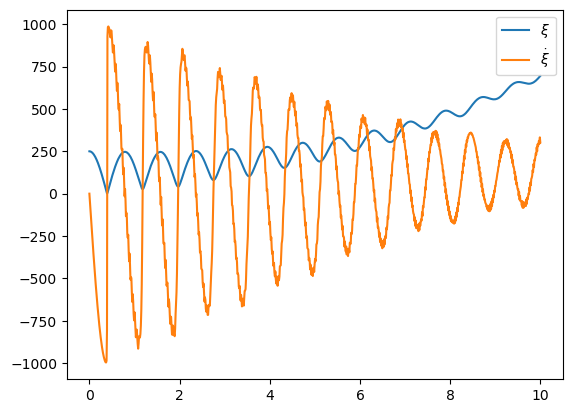

In [51]:
plt.plot(ans.t, xi, label=r'$\xi$')
plt.plot(ans.t, xi_d, label=r'$\dot{\xi}$')
plt.legend()

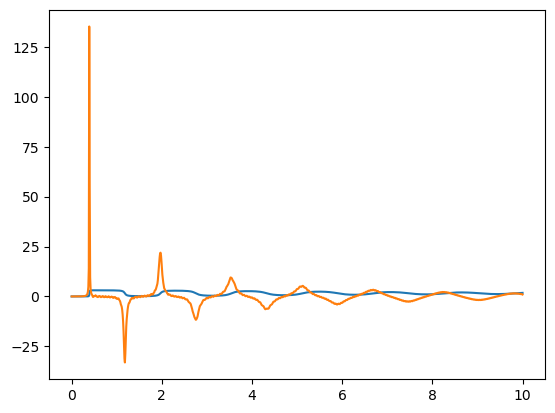

In [52]:
plt.plot(ans.t, phi)
plt.plot(ans.t, phi_d)

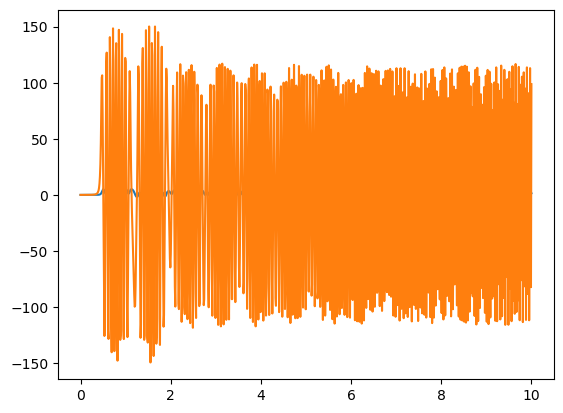

In [53]:
plt.plot(ans.t, psi)
plt.plot(ans.t, psi_d)